## 1. Import libraries

In [73]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import csv
import re # for regular expression
import string
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from collections import Counter 
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics  import confusion_matrix, classification_report, accuracy_score, roc_curve, auc

%matplotlib inline

In [61]:
np.random.seed(123)

## 2. Read and explore data

In [3]:
df_poems = pd.read_csv('all_poems.csv') 
df_poems.head()

poem_id                                          poem_link poem_style  \
0       21  http://www.adab.com/modules.php?name=Sh3er&doW...       فصحى   
1    65546  http://www.adab.com/modules.php?name=Sh3er&doW...       فصحى   
2    65561  http://www.adab.com/modules.php?name=Sh3er&doW...       فصحى   
3    65554  http://www.adab.com/modules.php?name=Sh3er&doW...       فصحى   
4    65550  http://www.adab.com/modules.php?name=Sh3er&doW...       فصحى   

                                           poem_text      poem_title poet_cat  \
0  عيناك غابتا نخيل ساعة السحر او شرفتان راح يناي...   أنشودة المطر    العراق   
1   انا لا ازال و في يدي قدحي ياليل اين تفرق الشر...  أقداح و أحلام    العراق   
2   علي مقلتيك ارتشفت النجوم وعانقت امالي الايبة ...     هوى واحد !    العراق   
3  اساطير من حشرجات الزمان نسيج اليد البالية رواه...         أساطير    العراق   
4  والتف حولك ساعداي ومال جيدك في اشتهاء كالزهرة ...  اللقاء الأخير    العراق   

   poet_id                                          poet_link        poet_name  
0        2  http://www.adab.com/modules.php?name=Sh3er&doW...  بدر شاكر السياب  
1        2  http://www.adab.com/modules.php?name=Sh3er&doW...  بدر شاكر السياب  
2        2  http://www.adab.com/modules.php?name=Sh3er&doW...  بدر شاكر السياب  
3        2  http://www.adab.com/modules.php?name=Sh3er&doW...  بدر شاكر السياب  
4        2  http://www.adab.com/modules.php?name=Sh3er&doW...  بدر شاكر السياب

In [93]:
df_poems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58021 entries, 0 to 58020
Data columns (total 9 columns):
poem_id       58021 non-null int64
poem_link     58021 non-null object
poem_style    58021 non-null object
poem_text     58020 non-null object
poem_title    58021 non-null object
poet_cat      58021 non-null object
poet_id       58021 non-null int64
poet_link     58021 non-null object
poet_name     58021 non-null object
dtypes: int64(2), object(7)
memory usage: 4.0+ MB


In [124]:
# Print a poem
df_poems.loc[10,'poem_text']

' هبت تغمغم سوف نفترق روح علي شفتيك تحترق صوت كان ضرام صاعقه ينداح فيه وقلبي الافق ضاق الفضاء وغام في بصري ضوء النجوم وحطم الالق فعلي جفوني الشاحبات وفي دمعي شظايا منه او مزق فيم الفراق اليس يجمعنا حب نظل عليه نعتنق حب ترقرق في الوعود سنا منه ورف علي الخطي عبق  اختاه صمتك ملءه الريب فيما الفراق اما له سب الحزن في عينيك مرتجف والياس في شفتيك يضطرب ويداك باردتان مثل غدي وعلي جبينك خاطر شجب ما زال سرك لا تجنحه اه مءجه ولا يثب حتي ضجرت به واسامه طول الثواء واده التعب اني اخاف عليك واختلجت شفه الي القبلات تلتهب  ثم انثنيت مهيضه الجلد تنهدين وتعصرين يدي وتردين وانت ذاهله اني اخاف عليك حزن غد فتكاد نتثرالنجوم اسي في جوهن كذاءب البرد لا تركي لا تركي لغدي تعكير يومي ما يكون غدي واذا ابتسمت اليوم من فرح فلتعبسن ملامح الابد ما كان عمري قبل موعدنا الا السنين تدب في جسد  اختاه لذ علي الهوي المي فاستمتعي بهواك وابتسمي هاتي الهيب فلست ارهبه ما كان حبك اول الحم ما زلت محترقا تلقفني نار من الاوهام كالظلم سوداء لا نور يضيء بها كرقاد حمي دونما حلم هاتي لهيبك ان فيه سنا يهدي خطاي ولو الي العدم هي ومضه الق

## 3. Clean the data  
#### 3.1 There is a null value in the 'poem_text' column. We will drop the entire row.

In [103]:
df_poems[df_poems['poem_text'].isnull() == True]

poem_id                                          poem_link poem_style  \
2454     6200  http://www.adab.com/modules.php?name=Sh3er&doW...       فصحى   

     poem_text poem_title poet_cat  poet_id  \
2454       NaN   الأشباح   البحرين       68   

                                              poet_link  poet_name  
2454  http://www.adab.com/modules.php?name=Sh3er&doW...  قاسم حداد

In [110]:
df_poems = df_poems.dropna()

#### 3.2 Remove any  'عامي' poem

In [111]:
df_poems.poem_style.value_counts()

فصحى    57893
-          33
Name: poem_style, dtype: int64

In [112]:
df_poems.drop(df_poems[df_poems.poem_style == 'عامي'].index, axis = 0, inplace=True)

df_poems.poem_style.value_counts()

فصحى    57893
-          33
Name: poem_style, dtype: int64

#### 3.2 Remove unnecessary columns

In [113]:
df_poems.drop(['poem_link', 'poet_link', 'poem_style'], axis = 1, inplace=True)

#### 3.3 Check if there are any duplicates in the 'poem_text' column

In [114]:
# Number of unique values 
df_poems.poem_text.nunique()

57599

In [115]:
# Show duplicate rows
df_poems[df_poems.duplicated(subset = ['poem_text'], keep=False) == True].head()

poem_id                                          poem_text  \
407     68884  ليس في وسعك يا سيدتي ان تصلحيني فلقد فات القطا...   
636     68900  ليس في وسعك يا سيدتي ان تصلحيني فلقد فات القطا...   
1365    67907   تلك المنازل كيف حال مقيمها انا قنعنا بعدها بر...   
1383    67926   تلك المنازل كيف حال مقيمها انا قنعنا بعدها بر...   
1773    66919  ذلك الرجل الذي استطاع اقتحام ملكتي علي صهوة رس...   

                      poem_title poet_cat  poet_id       poet_name  
407                    تَشَبُّث     سوريا        7      نزار قباني  
636                       تصميم     سوريا        7      نزار قباني  
1365                تلك المنازل     لبنان       31  إيليا أبو ماضي  
1383                تلك المنازل     لبنان       31  إيليا أبو ماضي  
1773  اشهد برجل على صهوة رسالة.     سوريا       35     غادة السمان

In [160]:
# Drop duplicates
df_poems.drop_duplicates(subset = ['poem_text'], keep='first', inplace=True)
df_poems.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57599 entries, 0 to 58020
Data columns (total 6 columns):
poem_id       57599 non-null int64
poem_text     57599 non-null object
poem_title    57599 non-null object
poet_cat      57599 non-null object
poet_id       57599 non-null int64
poet_name     57599 non-null object
dtypes: int64(2), object(4)
memory usage: 3.1+ MB


## 4. Preprocess the data

#### 4.1 Remove punctuations

In [116]:
# remove punctuations

arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''

def remove_punctuations(text):
    translator = str.maketrans('', '', arabic_punctuations)
    return text.translate(translator)


df_poems['poem_text'] = df_poems['poem_text'].apply(lambda x: remove_punctuations(x))


In [117]:
numbers = '،؛؟”0123456789“'

def remove_numbers(text):
    translator = str.maketrans('', '', numbers)
    return text.translate(translator)


df_poems['poem_text'] = df_poems['poem_text'].apply(lambda x: remove_numbers(x))



#### 4.2 Stemming 
Words are reduced to a root by removing inflection through dropping unnecessary characters.

In [118]:
# Using Farasa

#### 4.3 Normalize letters

In [119]:
# We can skip this step for better analysis

def normalize_arabic(text):
    
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    text = re.sub("ؤ", "و", text)

    return text


df_poems['poem_text'] = df_poems['poem_text'].apply(lambda x: normalize_arabic(x))



In [120]:
df_poems.head()

poem_id                                          poem_text      poem_title  \
0       21  عيناك غابتا نخيل ساعه السحر او شرفتان راح يناي...   أنشودة المطر    
1    65546   انا لا ازال و في يدي قدحي ياليل اين تفرق الشر...  أقداح و أحلام    
2    65561   علي مقلتيك ارتشفت النجوم وعانقت امالي الايبه ...     هوى واحد !    
3    65554  اساطير من حشرجات الزمان نسيج اليد الباليه رواه...         أساطير    
4    65550  والتف حولك ساعداي ومال جيدك في اشتهاء كالزهره ...  اللقاء الأخير    

  poet_cat  poet_id        poet_name  
0   العراق        2  بدر شاكر السياب  
1   العراق        2  بدر شاكر السياب  
2   العراق        2  بدر شاكر السياب  
3   العراق        2  بدر شاكر السياب  
4   العراق        2  بدر شاكر السياب

#### 4.2 Tokenizing &  Remove stop-words

In [164]:
# Show the set of Arabic stop-words
set(stopwords.words('arabic'))


{'آه',
 'آها',
 'آي',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'أم',
 'أما',
 'أن',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'أنى',
 'أو',
 'أولئك',
 'أولاء',
 'أوه',
 'أي',
 'أين',
 'أينما',
 'أيها',
 'إذ',
 'إذا',
 'إذما',
 'إذن',
 'إلا',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'إما',
 'إن',
 'إنا',
 'إنما',
 'إنه',
 'إي',
 'إيه',
 'التي',
 'الذي',
 'الذين',
 'اللائي',
 'اللاتي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بيد',
 'بين',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل',
 'على',
 'عليك',
 'عليه',
 'عم

In [121]:
# Pre-process the list

stop = stopwords.words('arabic')

stop = [normalize_arabic(i) for i in stop ]

In [122]:
# Delete duplicates in stop-word list

def del_duplicate(x):
  return list(dict.fromkeys(x))

stop_words = del_duplicate(stop)

print(len(stop_words))

237


In [123]:
# Add more stop-words to the list

stop_words.append(['و', 'ال', '\u200f', '-'])
print(len(stop_words))

238


In [125]:
# Split poem text into words
df_poems['poem_text'] = df_poems['poem_text'].str.split()
df_poems['poem_text'].head(10)

0    [عيناك, غابتا, نخيل, ساعه, السحر, او, شرفتان, ...
1    [انا, لا, ازال, و, في, يدي, قدحي, ياليل, اين, ...
2    [علي, مقلتيك, ارتشفت, النجوم, وعانقت, امالي, ا...
3    [اساطير, من, حشرجات, الزمان, نسيج, اليد, البال...
4    [والتف, حولك, ساعداي, ومال, جيدك, في, اشتهاء, ...
5    [اطلي, علي, طرفي, الدامع, خيالا, من, الكوكب, ا...
6    [اتبعيني, فالضحي, رانت, به, الذكري, علي, شط, ب...
7    [الداء, يثلج, راحتي, ويطفء, الغد, في, خيالي, و...
8    [سوف, امضي, اسمع, الريح, تناديني, بعيدا, في, ظ...
9    [--, اليل, والسوق, القديم, خفت, به, الاصوات, ا...
Name: poem_text, dtype: object

#### 4.3 Remove stop-words

In [188]:

df_poems['poem_text'] = df_poems['poem_text'].apply(lambda x: [item for item in tqdm(x) if item not in stop_words])



100%|██████████| 198/198 [00:00<00:00, 39726.01it/s]


  0%|          | 0/14 [00:00<?, ?it/s]


  0%|          | 0/55 [00:00<?, ?it/s]


100%|██████████| 79/79 [00:00<00:00, 19229.88it/s]


  0%|          | 0/134 [00:00<?, ?it/s]


  0%|          | 0/34 [00:00<?, ?it/s]


100%|██████████| 101/101 [00:00<00:00, 30793.39it/s]


100%|██████████| 303/303 [00:00<00:00, 58608.84it/s]


  0%|          | 0/232 [00:00<?, ?it/s]


  0%|          | 0/59 [00:00<?, ?it/s]


100%|██████████| 109/109 [00:00<00:00, 36080.75it/s]


  0%|          | 0/384 [00:00<?, ?it/s]


  0%|          | 0/1031 [00:00<?, ?it/s]


  0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 88/88 [00:00<00:00, 20436.23it/s]


  0%|          | 0/17 [00:00<?, ?it/s]


  0%|          | 0/86 [00:00<?, ?it/s]


100%|██████████| 195/195 [00:00<00:00, 73032.35it/s]


100%|██████████| 34/34 [00:00<00:00, 12512.62it/s]


  0%|          | 0/86 [00:00<?, ?it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


  0%|          | 0/103 [00:00<?, ?it/s]


  0%|          | 0/99 [00:00<?, ?it/s]


100%|██████████| 18/18 [00:00<00:00, 5451.47it/s]


  0%|          | 0/279 [00:00<?, ?it/s]


  0%|          | 0/58 [00:00<?, ?it/s]


100%|██████████| 25/25 [00:00<00:00, 9685.72it/s]


  0%|          | 0/81 [00:00<?, ?it/s]


100%|██████████| 32/32 [00:00<00:00, 10488.22it/s]


100%|██████████| 112/112 [00:00<00:00, 29961.23it/s]


  0%|          | 0/36 [00:00<?, ?it/s]


  0%|          | 0/72 [00:00<?, ?it/s]


  0%|          | 0/53 [00:00<?, ?it/s]


  0%|          | 0/63 [00:00<?, ?it/s]


  0%|          | 0/373 [00:00<?, ?it/s]


  0%|          | 0/526 [00:00<?, ?it/s]


100%|██████████| 479/479 [00:00<00:00, 62492.51it/s]


  0%|          | 0/31 [00:00<?, ?it/s]


100%|██████████| 61/61 [00:00<00:00, 12019.76it/s]


100%|██████████| 40/40 [00:00<00:00, 13803.86it/s]


  0%|          | 0/354 [00:00<?, ?it/s]


100%|██████████| 421/421 [00:00<00:00, 100329.66it/s]


  0%|          | 0/255 [00:00<?, ?it/s]


  0%|          | 0/84 [00:00<?, ?it/s]


100%|██████████| 12/12 [00:00<00:00, 3521.17it/s]


100%|██████████| 115/115 [00:00<00:00, 13941.01it/s]


  0%|          | 0/85 [00:00<?, ?it/s]


100%|██████████| 127/127 [00:00<00:00, 26337.53it/s]


  0%|          | 0/16 [00:00<?, ?it/s]


  0%|          | 0/30 [00:00<?, ?it/s]


100%|██████████| 23/23 [00:00<00:00, 9687.59it/s]


  0%|          | 0/61 [00:00<?, ?it/s]


100%|██████████| 123/123 [00:00<00:00, 33659.52it/s]


  0%|          | 0/265 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 2844.67it/s]


  0%|          | 0/138 [00:00<?, ?it/s]


100%|██████████| 31/31 [00:00<00:00, 8700.71it/s]


  0%|          | 0/405 [00:00<?, ?it/s]


100%|██████████| 21/21 [00:00<00:00, 6129.46it/s]


100%|██████████| 160/160 [00:00<00:00, 44325.54it/s]


100%|██████████| 35/35 [00:00<00:00, 7718.23it/s]


  0%|          | 0/41 [00:00<?, ?it/s]


100%|██████████| 18/18 [00:00<00:00, 4934.15it/s]


100%|██████████| 54/54 [00:00<00:00, 10104.95it/s]


  0%|          | 0/394 [00:00<?, ?it/s]


  0%|          | 0/68 [00:00<?, ?it/s]


  0%|          | 0/38 [00:00<?, ?it/s]


100%|██████████| 91/91 [00:00<00:00, 27600.09it/s]


100%|██████████| 15/15 [00:00<00:00, 4527.53it/s]


  0%|          | 0/74 [00:00<?, ?it/s]


100%|██████████| 139/139 [00:00<00:00, 39288.92it/s]


  0%|          | 0/197 [00:00<?, ?it/s]


100%|██████████| 113/113 [00:00<00:00, 25398.23it/s]


  0%|          | 0/48 [00:00<?, ?it/s]


  0%|          | 0/30 [00:00<?, ?it/s]


100%|██████████| 137/137 [00:00<00:00, 27471.42it/s]


100%|██████████| 48/48 [00:00<00:00, 11982.30it/s]


  0%|          | 0/77 [00:00<?, ?it/s]


100%|██████████| 62/62 [00:00<00:00, 20413.44it/s]


100%|██████████| 37/37 [00:00<00:00, 16809.93it/s]


  0%|          | 0/37 [00:00<?, ?it/s]


  0%|          | 0/25 [00:00<?, ?it/s]


  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/45 [00:00<?, ?it/s]


100%|██████████| 121/121 [00:00<00:00, 30431.78it/s]


100%|██████████| 239/239 [00:00<00:00, 54865.01it/s]


  0%|          | 0/107 [00:00<?, ?it/s]


100%|██████████| 18/18 [00:00<00:00, 5778.60it/s]


  0%|          | 0/19 [00:00<?, ?it/s]


  0%|          | 0/534 [00:00<?, ?it/s]


100%|██████████| 260/260 [00:00<00:00, 65591.18it/s]


  0%|          | 0/19 [00:00<?, ?it/s]


100%|██████████| 444/444 [00:00<00:00, 81678.55it/s]
0it [00:00, ?it/s]
  0%|          | 0/225 [00:00<?, ?it/s]


100%|██████████| 22/22 [00:00<00:00, 3718.80it/s]


  0%|          | 0/13 [00:00<?, ?it/s]


  0%|          | 0/27 [00:00<?, ?it/s]


  0%|          | 0/29 [00:00<?, ?it/s]


100%|██████████| 534/534 [00:00<00:00, 88971.09it/s]


  0%|          | 0/836 [00:00<?, ?it/s]


100%|██████████| 486/486 [00:00<00:00, 82444.16it/s]


  0%|          | 0/34 [00:00<?, ?it/s]


100%|██████████| 17/17 [00:00<00:00, 5371.24it/s]


  0%|          | 0/203 [00:00<?, ?it/s]


  0%|          | 0/57 [00:00<?, ?it/s]


100%|██████████| 271/271 [00:00<00:00, 64770.44it/s]


100%|██████████| 55/55 [00:00<00:00, 15731.50it/s]


  0%|          | 0/50 [00:00<?, ?it/s]


  0%|          | 0/30 [00:00<?, ?it/s]


  0%|          | 0/35 [00:00<?, ?it/s]


  0%|          | 0/376 [00:00<?, ?it/s]


  0%|          | 0/418 [00:00<?, ?it/s]


  0%|          | 0/34 [00:00<?, ?it/s]


  0%|          | 0/21 [00:00<?, ?it/s]


100%|██████████| 1091/1091 [00:00<00:00, 145815.62it/s]


100%|██████████| 73/73 [00:00<00:00, 22658.49it/s]


100%|██████████| 71/71 [00:00<00:00, 14201.71it/s]


  0%|          | 0/19 [00:00<?, ?it/s]


  0%|          | 0/18 [00:00<?, ?it/s]


100%|██████████| 19/19 [00:00<00:00, 7636.24it/s]


100%|██████████| 19/19 [00:00<00:00, 6083.81it/s]


  0%|          | 0/22 [00:00<?, ?it/s]


  0%|          | 0/1108 [00:00<?, ?it/s]


100%|██████████| 401/401 [00:00<00:00, 95934.06it/s]


  0%|          | 0/53 [00:00<?, ?it/s]


100%|██████████| 11/11 [00:00<00:00, 3579.59it/s]


  0%|          | 0/411 [00:00<?, ?it/s]


  0%|          | 0/635 [00:00<?, ?it/s]


  0%|          | 0/26 [00:00<?, ?it/s]


  0%|          | 0/30 [00:00<?, ?it/s]


100%|██████████| 55/55 [00:00<00:00, 16560.42it/s]


  0%|          | 0/28 [00:00<?, ?it/s]


100%|██████████| 66/66 [00:00<00:00, 20312.89it/s]


100%|██████████| 288/288 [00:00<00:00, 67969.81it/s]


100%|██████████| 25/25 [00:00<00:00, 6277.02it/s]


100%|██████████| 116/116 [00:00<00:00, 32814.41it/s]


100%|██████████| 64/64 [00:00<00:00, 16671.97it/s]


100%|██████████| 16/16 [00:00<00:00, 5459.11it/s]


  0%|          | 0/19 [00:00<?, ?it/s]


  0%|          | 0/25 [00:00<?, ?it/s]


  0%|          | 0/500 [00:00<?, ?it/s]


  0%|          | 0/59 [00:00<?, ?it/s]


  0%|          | 0/21 [00:00<?, ?it/s]


  0%|          | 0/47 [00:00<?, ?it/s]


  0%|          | 0/82 [00:00<?, ?it/s]


  0%|          | 0/17 [00:00<?, ?it/s]


100%|██████████| 19/19 [00:00<00:00, 10248.43it/s]


  0%|          | 0/26 [00:00<?, ?it/s]


100%|██████████| 774/774 [00:00<00:00, 128963.23it/s]


100%|██████████| 386/386 [00:00<00:00, 50137.85it/s]


  0%|          | 0/32 [00:00<?, ?it/s]


100%|██████████| 518/518 [00:00<00:00, 94925.27it/s]


  0%|          | 0/642 [00:00<?, ?it/s]


100%|██████████| 331/331 [00:00<00:00, 45731.43it/s]


  0%|          | 0/294 [00:00<?, ?it/s]


  0%|          | 0/234 [00:00<?, ?it/s]


100%|██████████| 55/55 [00:00<00:00, 20776.97it/s]


  0%|          | 0/488 [00:00<?, ?it/s]


  0%|          | 0/17 [00:00<?, ?it/s]


100%|██████████| 36/36 [00:00<00:00, 8801.80it/s]


100%|██████████| 20/20 [00:00<00:00, 5109.71it/s]


100%|██████████| 18/18 [00:00<00:00, 5596.97it/s]


  0%|          | 0/11 [00:00<?, ?it/s]


100%|██████████| 302/302 [00:00<00:00, 53586.59it/s]


  0%|          | 0/9 [00:00<?, ?it/s]


100%|██████████| 10/10 [00:00<00:00, 3072.98it/s]


  0%|          | 0/60 [00:00<?, ?it/s]


  0%|          | 0/20 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 2536.54it/s]


  0%|          | 0/80 [00:00<?, ?it/s]


  0%|          | 0/16 [00:00<?, ?it/s]


  0%|          | 0/21 [00:00<?, ?it/s]


  0%|          | 0/95 [00:00<?, ?it/s]


  0%|          | 0/143 [00:00<?, ?it/s]


100%|██████████| 40/40 [00:00<00:00, 12663.01it/s]


100%|██████████| 219/219 [00:00<00:00, 48786.52it/s]


  0%|          | 0/152 [00:00<?, ?it/s]


100%|██████████| 483/483 [00:00<00:00, 77818.49it/s]


100%|██████████| 106/106 [00:00<00:00, 23789.19it/s]


100%|██████████| 20/20 [00:00<00:00, 7288.74it/s]


  0%|          | 0/552 [00:00<?, ?it/s]


  0%|          | 0/46 [00:00<?, ?it/s]


100%|██████████| 45/45 [00:00<00:00, 9087.32it/s]


  0%|          | 0/22 [00:00<?, ?it/s]


  0%|          | 0/249 [00:00<?, ?it/s]


  0%|          | 0/173 [00:00<?, ?it/s]


  0%|          | 0/330 [00:00<?, ?it/s]


  0%|          | 0/321 [00:00<?, ?it/s]


  0%|          | 0/20 [00:00<?, ?it/s]


  0%|          | 0/89 [00:00<?, ?it/s]


100%|██████████| 59/59 [00:00<00:00, 17986.91it/s]


  0%|          | 0/249 [00:00<?, ?it/s]


  0%|          | 0/22 [00:00<?, ?it/s]


  0%|          | 0/54 [00:00<?, ?it/s]


  0%|          | 0/87 [00:00<?, ?it/s]


100%|██████████| 5/5 [00:00<00:00, 1774.24it/s]


  0%|          | 0/557 [00:00<?, ?it/s]


  0%|          | 0/90 [00:00<?, ?it/s]


  0%|          | 0/98 [00:00<?, ?it/s]


  0%|          | 0/174 [00:00<?, ?it/s]


  0%|          | 0/93 [00:00<?, ?it/s]


100%|██████████| 102/102 [00:00<00:00, 21967.60it/s]


100%|██████████| 90/90 [00:00<00:00, 28373.97it/s]


  0%|          | 0/117 [00:00<?, ?it/s]


100%|██████████| 17/17 [00:00<00:00, 3582.71it/s]


100%|██████████| 26/26 [00:00<00:00, 8165.01it/s]


100%|██████████| 15/15 [00:00<00:00, 2779.77it/s]


  0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 52/52 [00:00<00:00, 9191.83it/s]


  0%|          | 0/22 [00:00<?, ?it/s]


  0%|          | 0/143 [00:00<?, ?it/s]


  0%|          | 0/97 [00:00<?, ?it/s]


  0%|          | 0/47 [00:00<?, ?it/s]


  0%|          | 0/91 [00:00<?, ?it/s]


  0%|          | 0/110 [00:00<?, ?it/s]


  0%|          | 0/19 [00:00<?, ?it/s]


  0%|          | 0/112 [00:00<?, ?it/s]


  0%|          | 0/67 [00:00<?, ?it/s]


  0%|          | 0/27 [00:00<?, ?it/s]


100%|██████████| 83/83 [00:00<00:00, 20468.44it/s]


  0%|          | 0/349 [00:00<?, ?it/s]


  0%|          | 0/26 [00:00<?, ?it/s]


  0%|          | 0/41 [00:00<?, ?it/s]


100%|██████████| 83/83 [00:00<00:00, 17060.88it/s]


  0%|          | 0/36 [00:00<?, ?it/s]


100%|██████████| 42/42 [00:00<00:00, 11497.99it/s]


100%|██████████| 159/159 [00:00<00:00, 38874.63it/s]


  0%|          | 0/25 [00:00<?, ?it/s]


100%|██████████| 152/152 [00:00<00:00, 37383.27it/s]


  0%|          | 0/61 [00:00<?, ?it/s]


100%|██████████| 117/117 [00:00<00:00, 21451.90it/s]


100%|██████████| 55/55 [00:00<00:00, 14229.38it/s]


  0%|          | 0/165 [00:00<?, ?it/s]


100%|██████████| 59/59 [00:00<00:00, 27416.79it/s]


100%|██████████| 832/832 [00:00<00:00, 126675.65it/s]


100%|██████████| 15/15 [00:00<00:00, 5309.25it/s]


  0%|          | 0/251 [00:00<?, ?it/s]


  0%|          | 0/167 [00:00<?, ?it/s]


  0%|          | 0/192 [00:00<?, ?it/s]


100%|██████████| 383/383 [00:00<00:00, 60201.56it/s]


100%|██████████| 20/20 [00:00<00:00, 5212.58it/s]


100%|██████████| 268/268 [00:00<00:00, 46279.12it/s]


100%|██████████| 237/237 [00:00<00:00, 46252.10it/s]


100%|██████████| 67/67 [00:00<00:00, 18539.28it/s]


  0%|          | 0/79 [00:00<?, ?it/s]


  0%|          | 0/504 [00:00<?, ?it/s]


100%|██████████| 125/125 [00:00<00:00, 23147.37it/s]


  0%|          | 0/27 [00:00<?, ?it/s]


100%|██████████| 564/564 [00:00<00:00, 93390.74it/s]


100%|██████████| 357/357 [00:00<00:00, 83670.46it/s]


100%|██████████| 1114/1114 [00:00<00:00, 117596.32it/s]


  0%|          | 0/43 [00:00<?, ?it/s]


100%|██████████| 130/130 [00:00<00:00, 26700.92it/s]


  0%|          | 0/114 [00:00<?, ?it/s]


  0%|          | 0/195 [00:00<?, ?it/s]


  0%|          | 0/198 [00:00<?, ?it/s]


100%|██████████| 237/237 [00:00<00:00, 25355.83it/s]


  0%|          | 0/129 [00:00<?, ?it/s]


  0%|          | 0/45 [00:00<?, ?it/s]


100%|██████████| 55/55 [00:00<00:00, 17600.27it/s]


  0%|          | 0/155 [00:00<?, ?it/s]


  0%|          | 0/161 [00:00<?, ?it/s]


100%|██████████| 31/31 [00:00<00:00, 4884.24it/s]


100%|██████████| 57/57 [00:00<00:00, 9939.11it/s]


100%|██████████| 13/13 [00:00<00:00, 4128.25it/s]


  0%|          | 0/10 [00:00<?, ?it/s]


  0%|          | 0/23 [00:00<?, ?it/s]


  0%|          | 0/142 [00:00<?, ?it/s]


100%|██████████| 62/62 [00:00<00:00, 17299.55it/s]


  0%|          | 0/39 [00:00<?, ?it/s]


  0%|          | 0/13 [00:00<?, ?it/s]


100%|██████████| 31/31 [00:00<00:00, 6816.43it/s]


100%|██████████| 447/447 [00:00<00:00, 81957.24it/s]


  0%|          | 0/77 [00:00<?, ?it/s]


100%|██████████| 260/260 [00:00<00:00, 44089.88it/s]


100%|██████████| 329/329 [00:00<00:00, 44597.18it/s]


  0%|          | 0/135 [00:00<?, ?it/s]


  0%|          | 0/186 [00:00<?, ?it/s]


100%|██████████| 80/80 [00:00<00:00, 11198.25it/s]


  0%|          | 0/23 [00:00<?, ?it/s]


100%|██████████| 15/15 [00:00<00:00, 3810.92it/s]


100%|██████████| 276/276 [00:00<00:00, 68179.98it/s]


100%|██████████| 13/13 [00:00<00:00, 1960.52it/s]


100%|██████████| 205/205 [00:00<00:00, 35708.81it/s]


100%|██████████| 180/180 [00:00<00:00, 25056.41it/s]


  0%|          | 0/34 [00:00<?, ?it/s]


  0%|          | 0/18 [00:00<?, ?it/s]


100%|██████████| 65/65 [00:00<00:00, 20832.11it/s]


100%|██████████| 20/20 [00:00<00:00, 6408.41it/s]


100%|██████████| 75/75 [00:00<00:00, 6361.30it/s]


100%|██████████| 67/67 [00:00<00:00, 5189.44it/s]


  0%|          | 0/180 [00:00<?, ?it/s]


  0%|          | 0/126 [00:00<?, ?it/s]


  0%|          | 0/136 [00:00<?, ?it/s]


  0%|          | 0/40 [00:00<?, ?it/s]


  0%|          | 0/62 [00:00<?, ?it/s]


100%|██████████| 149/149 [00:00<00:00, 34652.14it/s]


  0%|          | 0/239 [00:00<?, ?it/s]


  0%|          | 0/289 [00:00<?, ?it/s]


100%|██████████| 214/214 [00:00<00:00, 52069.91it/s]


100%|██████████| 312/312 [00:00<00:00, 66272.81it/s]


  0%|          | 0/14 [00:00<?, ?it/s]


  0%|          | 0/131 [00:00<?, ?it/s]


100%|██████████| 116/116 [00:00<00:00, 25522.70it/s]


  0%|          | 0/128 [00:00<?, ?it/s]


  0%|          | 0/248 [00:00<?, ?it/s]


100%|██████████| 215/215 [00:00<00:00, 73554.27it/s]


  0%|          | 0/361 [00:00<?, ?it/s]


  0%|          | 0/173 [00:00<?, ?it/s]


  0%|          | 0/58 [00:00<?, ?it/s]


  0%|          | 0/307 [00:00<?, ?it/s]


  0%|          | 0/161 [00:00<?, ?it/s]


100%|██████████| 23/23 [00:00<00:00, 6721.17it/s]


100%|██████████| 200/200 [00:00<00:00, 51638.09it/s]


  0%|          | 0/108 [00:00<?, ?it/s]


  0%|          | 0/79 [00:00<?, ?it/s]


  0%|          | 0/121 [00:00<?, ?it/s]


100%|██████████| 63/63 [00:00<00:00, 12347.72it/s]


100%|██████████| 40/40 [00:00<00:00, 7134.08it/s]


  0%|          | 0/490 [00:00<?, ?it/s]


  0%|          | 0/71 [00:00<?, ?it/s]


  0%|          | 0/129 [00:00<?, ?it/s]


100%|██████████| 176/176 [00:00<00:00, 44386.84it/s]


100%|██████████| 208/208 [00:00<00:00, 34702.28it/s]


100%|██████████| 18/18 [00:00<00:00, 5046.29it/s]


100%|██████████| 97/97 [00:00<00:00, 26178.98it/s]


  0%|          | 0/47 [00:00<?, ?it/s]


  0%|          | 0/120 [00:00<?, ?it/s]


  0%|          | 0/148 [00:00<?, ?it/s]


100%|██████████| 252/252 [00:00<00:00, 27987.94it/s]


100%|██████████| 51/51 [00:00<00:00, 21081.06it/s]


  0%|          | 0/226 [00:00<?, ?it/s]


  0%|          | 0/173 [00:00<?, ?it/s]


100%|██████████| 122/122 [00:00<00:00, 27502.15it/s]


  0%|          | 0/11 [00:00<?, ?it/s]


  0%|          | 0/22 [00:00<?, ?it/s]


  0%|          | 0/395 [00:00<?, ?it/s]


  0%|          | 0/29 [00:00<?, ?it/s]


100%|██████████| 28/28 [00:00<00:00, 4789.58it/s]


100%|██████████| 333/333 [00:00<00:00, 55059.85it/s]


100%|██████████| 639/639 [00:00<00:00, 144607.76it/s]


  0%|          | 0/392 [00:00<?, ?it/s]


  0%|          | 0/101 [00:00<?, ?it/s]


  0%|          | 0/176 [00:00<?, ?it/s]


100%|██████████| 55/55 [00:00<00:00, 13359.20it/s]


  0%|          | 0/93 [00:00<?, ?it/s]


100%|██████████| 46/46 [00:00<00:00, 20490.44it/s]

In [126]:
df_poems['poem_text'].loc[100]

['الاسلحه',
 'والاطفال',
 'عصافير',
 'ام',
 'صبيه',
 'تمرح',
 'عليها',
 'سنا',
 'من',
 'غد',
 'يلمح',
 'واقدامها',
 'العاريه',
 'محار',
 'يصلصل',
 'في',
 'ساقيه',
 'لاذيالهم',
 'رفه',
 'الشمال',
 'سرت',
 'عبر',
 'حقل',
 'من',
 'السنبل',
 'وهسهسه',
 'الخبز',
 'في',
 'يوم',
 'عيد',
 'وغمغمه',
 'الام',
 'باسم',
 'الوليد',
 'تناغيه',
 'في',
 'يومه',
 'الاول',
 'كاني',
 'اسمع',
 'خفق',
 'القلوع',
 'وتصخاب',
 'بحاره',
 'السندباد',
 'راي',
 'كتره',
 'الضخم',
 'بين',
 'الضلوع',
 'فما',
 'اختار',
 'الاه',
 'كترا',
 'وعادا',
 'صدي',
 'عابر',
 'من',
 'وراء',
 'العصور',
 'من',
 'الكهف',
 'والغاب',
 'والمعبد',
 'سري',
 'دافءا',
 'من',
 'عروق',
 'الصخور',
 'وازميل',
 'نحاتها',
 'المجهد',
 'يغني',
 'باشواقه',
 'العاتيه',
 'الينا',
 'الي',
 'القمه',
 'العاليه',
 'الي',
 'ان',
 'يفل',
 'الردي',
 'بالحياه',
 'وتلقاه',
 'اجيالها',
 'الاتيه',
 'علي',
 'صخره',
 'حملتها',
 'يداه',
 'تحاياه',
 'في',
 'بسمه',
 'في',
 'الشفاه',
 'وفي',
 'اعين',
 'حجرت',
 'مقلتاه',
 'عليها',
 'دموعها',
 'الجاريه',
 'صدي',
 'رجع

In [191]:
# Save the tokenized poems into file
df_poems.to_csv('all_poems_tokens.csv', encoding='utf-8')

In [4]:
df_poems = pd.read_csv('all_poems_tokens.csv') 
df_poems.head()

Unnamed: 0  poem_id                                          poem_text  \
0           0       21  ['عيناك', 'غابتا', 'نخيل', 'ساعه', 'السحر', 'ش...   
1           1    65546  ['ازال', 'يدي', 'قدحي', 'ياليل', 'تفرق', 'الشر...   
2           2    65561  ['مقلتيك', 'ارتشفت', 'النجوم', 'وعانقت', 'امال...   
3           3    65554  ['اساطير', 'حشرجات', 'الزمان', 'نسيج', 'اليد',...   
4           4    65550  ['والتف', 'حولك', 'ساعداي', 'ومال', 'جيدك', 'ا...   

       poem_title poet_cat  poet_id        poet_name  
0   أنشودة المطر    العراق        2  بدر شاكر السياب  
1  أقداح و أحلام    العراق        2  بدر شاكر السياب  
2     هوى واحد !    العراق        2  بدر شاكر السياب  
3         أساطير    العراق        2  بدر شاكر السياب  
4  اللقاء الأخير    العراق        2  بدر شاكر السياب

## 4. Explore Data

#### 4.1  Visualize poems categories

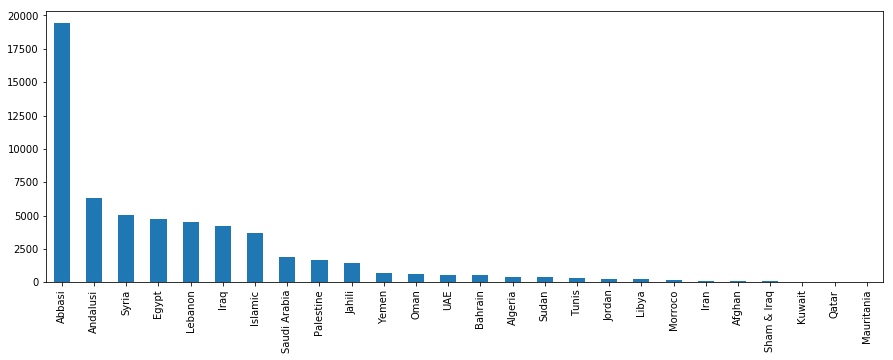

In [5]:
df_poems.poet_cat.value_counts().plot(kind='bar', figsize=(15, 5))
plt.xticks(np.arange(26), ('Abbasi','Andalusi', 'Syria', 'Egypt', 'Lebanon', 'Iraq', 'Islamic', 'Saudi Arabia', 
'Palestine','Jahili','Yemen','Oman','UAE','Bahrain', 'Algeria', 'Sudan', 'Tunis', 'Jordan', 'Libya', 'Morroco', 'Iran', 'Afghan'
                          ,'Sham & Iraq', 'Kuwait', 'Qatar', 'Mauritania'))
plt.show()

#### 4.2 Visualize top poets in the dataset

In [6]:
top_poets = df_poems.poet_name.value_counts()[df_poems.poet_name.value_counts() > 500]
print(top_poets)

ابن الرومي             2134
أبوالعلاء المعري       1593
ابن نباتة المصري       1534
جبران خليل جبران       1148
عبد الغني النابلسي     1114
البحتري                 959
محيي الدين  بن عربي     860
أبو نواس                821
صفي الدين الحلي         811
ابن المعتز              762
الشريف الرضي            676
خليل مطران              645
بشار بن برد             626
نزار قباني              604
الفرزدق                 601
الشريف المرتضى          570
أسامة بن منقذ           521
Name: poet_name, dtype: int64


#### 4.3 Top words used in the poems

#### 4.4 Top words in each poem's category 

## 5.  Feature Engineering

Make a new group in 'poet_cat' and call it 'العصر الحديث'

In [7]:
df_poems.poet_cat.value_counts() 

العصر العباسي          19399
العصر الأندلسي          6292
سوريا                   5031
مصر                     4764
لبنان                   4544
العراق                  4221
العصر الإسلامي          3696
السعودية                1927
فلسطين                  1708
العصر الجاهلي           1457
اليمن                    697
عمان                     607
الإمارات                 563
البحرين                  551
الجزائر                  404
السودان                  374
تونس                     351
الأردن                   263
ليبيا                    238
المغرب                   201
إيران                     90
أفغانستان                 70
شعراء العراق والشام       68
الكويت                    54
موريتانيا                 15
قطر                       14
Name: poet_cat, dtype: int64

In [5]:
modern = ['شعراء العراق والشام','الأردن','العراق' ,'مصر' ,'سوريا' ,'لبنان' ,'فلسطين' ,'السعودية' ,'اليمن' ,'عمان',
          'الإمارات', 'البحرين' ,'الجزائر','ليبيا','المغرب','الكويت' ,'قطر',
          'موريتانيا', 'أفغانستان', 'إيران', 'السودان', 'تونس']

not_modern = ['العصر العباسي', 'العصر الأندلسي', 'العصر الجاهلي', 'العصر الجاهلي', 'العصر الإسلامي']

df_poems['modern'] = df_poems['poet_cat']

df_poems['modern'] = df_poems['modern'].replace(modern, 1)
df_poems['modern'] = df_poems['modern'].replace(not_modern, 0)



In [6]:
df_poems['modern'].value_counts()

0    30844
1    26755
Name: modern, dtype: int64

## 6.  Poems Classification

#### 6.1 Prepare data

In [7]:
# Training Phase

X_train, X_test, y_train, y_test = train_test_split(df_poems['poem_text'], df_poems['modern'], test_size=0.3, 
                                                    random_state=0, stratify=df_poems['modern'])


In [8]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(y_train)
Test_Y = Encoder.fit_transform(y_test)

Term Frequency-Inverse Document Frequency (TF-IDF)
Frequency which are the components of the resulting scores assigned to each word.
Term Frequency: This summarizes how often a given word appears within a document.
Inverse Document Frequency: This down scales words that appear a lot across documents.
Without going into the math, TF-IDF are word frequency scores that try to highlight words that are more interesting, e.g. frequent in a document but not across documents.


In [50]:
Tfidf_vect = TfidfVectorizer(max_features=500, min_df=10, max_df=0.7)

Tfidf_vect.fit(df_poems['poem_text'])
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

/Users/nourainclub/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [51]:
print(Tfidf_vect.vocabulary_)

{'ساعه': 282, 'راح': 267, 'القمر': 128, 'النجوم': 157, 'المساء': 147, 'ملء': 428, 'روحي': 276, 'السماء': 90, 'المطر': 148, 'صمت': 303, 'بات': 199, 'قبل': 369, 'بان': 201, 'امه': 189, 'عام': 312, 'فلم': 352, 'قالوا': 367, 'بد': 203, 'انها': 192, 'حزن': 245, 'وكيف': 470, 'بلا': 213, 'كانها': 385, 'اليل': 179, 'عليها': 319, 'دم': 261, 'كانه': 384, 'عنها': 329, 'الرجال': 80, 'الرياح': 84, 'اثر': 7, 'وفي': 463, 'وكم': 468, 'ليله': 407, 'كنا': 394, 'كانت': 383, 'وكل': 467, 'الثري': 50, 'مر': 419, 'الزهر': 88, 'فهي': 359, 'جديد': 235, 'عالم': 311, 'الفتي': 121, 'الحياه': 66, 'تبقي': 220, 'ظل': 309, 'الردي': 81, 'الف': 119, 'يدي': 489, 'زلت': 279, 'الشرق': 93, 'فما': 356, 'الحب': 55, 'قلب': 374, 'كفي': 390, 'الدنيا': 76, 'لان': 398, 'ليل': 406, 'عنه': 328, 'دمي': 263, 'يد': 488, 'الحمي': 63, 'عين': 333, 'نفسي': 439, 'كنت': 395, 'صوت': 304, 'البحر': 43, 'وانا': 445, 'الفجر': 122, 'امل': 188, 'مثل': 412, 'عاد': 310, 'بيض': 217, 'حلم': 250, 'عمري': 322, 'قلبي': 376, 'لكل': 401, 'التراب': 49, 'تري

#### 6.1 Plot Features

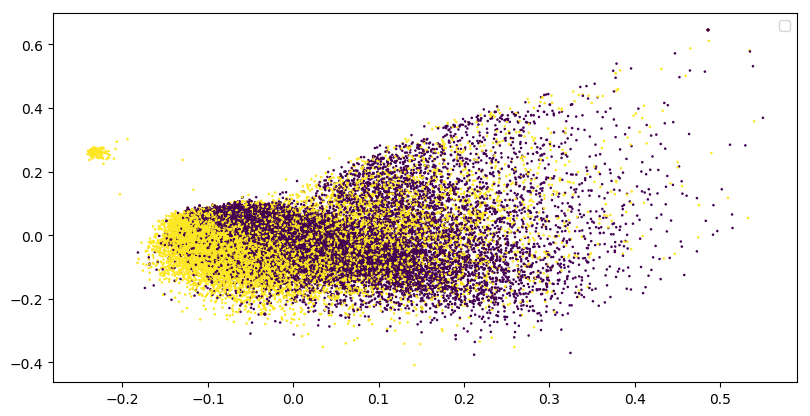

In [78]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

plt.figure(figsize=plt.figaspect(0.5))   # figure size
plt.rcParams.update(plt.rcParamsDefault) # the default parameters

pca = PCA(n_components=2)
pca.fit(Train_X_Tfidf.todense())
vals1 = pca.transform(Train_X_Tfidf.todense())

#plt.legend(['Modern', 'Not modern'])
plt.scatter(vals1[:,0], vals1[:,1], c = Train_Y, s =0.7)


#### 6.2 Naive Bayes 

In [53]:
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
nb_model = GaussianNB()

# Train the model using the training sets
nb_model.fit(Train_X_Tfidf.todense(), Train_Y)

#Predict Output
predictions_NB= nb_model.predict(Test_X_Tfidf.todense())
print ("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y) * 100)

Naive Bayes Accuracy Score ->  75.9375


#### 6.3 Logistic Regression

In [54]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression()
LR_model.fit(Train_X_Tfidf.todense(), Train_Y)
predictions_LR = LR_model.predict(Test_X_Tfidf.todense())

print ("Logistic Regression Accuracy Score -> ",accuracy_score(predictions_LR, Test_Y) * 100)

Logistic Accuracy Score ->  79.9074074074074


In [62]:
#do a 10 fold cross-validation 
results_LR = cross_val_score(LR_model, Train_X_Tfidf.todense(), Train_Y, cv=10)
print("\n10-fold cross-validation:")
print(results_LR)

print("The average accuracy of the Logistic Regression classifier is :", np.mean(results_LR)* 100)


10-fold cross-validation:
[0.79320605 0.79985119 0.79290675 0.78943452 0.80431548 0.79935516
 0.79985119 0.79811508 0.79980154 0.80377078]
The average accuracy of the Logistic Regression classifier is : 79.80607729728291


In [64]:
print("\nConfusion matrix of the Logistic Regression classifier:")
predicted_LR = LR_model.predict(Test_X_Tfidf.todense())
print(confusion_matrix(Test_Y,predicted_LR))


Confusion matrix of the Logistic Regression classifier:
[[8074 1179]
 [2293 5734]]


In [65]:
print("\nClassification_report of Logistic Regression classifier:")
print(classification_report(Test_Y,predicted_LR))
print("----------------------------------------------------------------------------")


Classification_report of SVM classifier:
             precision    recall  f1-score   support

          0       0.78      0.87      0.82      9253
          1       0.83      0.71      0.77      8027

avg / total       0.80      0.80      0.80     17280

----------------------------------------------------------------------------


In [74]:
# calculate the fpr and tpr for all thresholds of the classification
probs = LR_model.predict_proba(Test_X_Tfidf.todense())
preds = probs[:,1]

fpr, tpr, threshold =  roc_curve(Test_Y, preds)
roc_auc = auc(fpr, tpr)

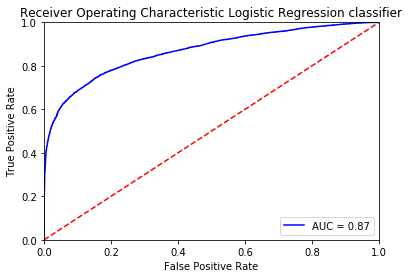

In [76]:
# plot the AUC
plt.title('Receiver Operating Characteristic Logistic Regression classifier')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()